# TASK-1 ENSAMBLES

Viene ripetuta l'analisi essenziale dell'indice ElNino 3.4 eseguita per tutti i membri storici (Hist) disponibili di EC-Earth:
- calcolo dell'indice attraverso la running mean di 30 anni (con min_periods=1 per evitare il data loss)
- Calcolo della deviazione standard come valore totale

In [1]:
# import libraries
import numpy as np
import xarray as xr
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import AllePowerFunctions as apf
import climtools_lib as ctl

No DISPLAY variable set. Switching to agg backend


In [2]:
# Comando che rende le immagini generate visualizzabili
%matplotlib inline

In [ ]:
#################################################################################################################################################
######################### Analisi d'Ensamble dell'indice Nino 3.4 per i memebridisponibili dello Storico ########################################
#################################################################################################################################################
# Directories
common_dir_proj = '/home/montanarini/ELNINO/'
common_dir_dat = '/nas/BOTTINO/CMIP6/LongRunMIP/EC-Earth-Consortium/EC-Earth3/historical/'
Dir_Dataset = '{}/Omon/tos/*.nc'
Dir_obs = '/nas/reference/HadISST/2020/HadISST_sst.nc'
Dir_images = 'images/Task-1_HistEnsambles/'
Dir_outputs = 'output/Task-1_HistEnsambles/Variables/'
ensamble_names = ['r101i1p1f1', 'r102i1p1f1', 'r103i1p1f1', 'r104i1p1f1', 'r105i1p1f1', 'r106i1p1f1', 'r107i1p1f1', 'r4i1p1f1']

# Dataset di riferimento per il regridding. E' un singolo file con tutti gli anni invece che un file per anno come gli altri.
Dir_rif = common_dir_dat + ensamble_names[7] + '/Omon/tos_rg_1850-2014.nc'
rif = xr.open_dataset(Dir_rif)

# Creazione del dizionario
Datasets = {}

print('Inizio del ciclo')
time_in = datetime.now()
for ensamble in ensamble_names:
    print("\n", f'Inizio elaborazione membro {ensamble}')
    time_in_en = datetime.now()
    if ensamble not in Datasets:  # Controlla se il dizionario per il dataset esiste, altrimenti crealo
        # Creazione di dizionari annidati: uno per ogni ensamble member
        Datasets[ensamble] = {}

    # Acquisizione dei dati
    Datasets[ensamble] = xr.open_mfdataset(common_dir_dat+Dir_Dataset.format(ensamble))
    # Regridding
    Datasets[ensamble] = ctl.regrid_dataset(Datasets[ensamble], regrid_to_reference=rif)
    # Passaggio al DataArray
    sst = Datasets[ensamble]['tos']
    # Estrazione coordinate
    time = sst['time']
    lon = sst['lon']
    lat = sst['lat'] 

    # Calcolo dell'indice Nino 3.4
    print("\n","Start computing the Index")
    Index34 = apf.nino_index(sst)
    print("\n","End of computing the Index")

    # Calcolo del Power Spectra
    print("\n","Start computing the Power Spectra")
    freqs, power_spec = apf.power_spectra(Index34, 0)
    print("\n","End of computing the Power Spectra")

    # Calcolo della STD
    print("\n","Start computing the Standard Deviations")
    std_T, std_window, std_RM =  apf.standard_deviation(Index34, 120, 45, 'time') # RM di 120 mesi e ultimi 45 anni (quest'ultimo serve solamente per il r4i1p1f1)
    print("\n","End of computing the Standard Deviations")

    # Salvataggio delle variabili
    print("\n","Start saving the evaluated variables")
    pickle.dump([Index34, freqs, power_spec,
                std_T, std_window, std_RM], open(common_dir_proj+Dir_outputs + f'Task-1_HistEnsambles-{ensamble}.p', 'wb'))
    print("\n","End saving the evaluated variables")
    print("\n","STD recaps")
    print(std_T, "\n", std_window)
    print(f'Fine elaborazione membro {ensamble} \nElaborazione ha impiegato:\n')
    time_fin_en = datetime.now()
    print(time_fin_en-time_in_en)
print('fine del ciclo')

print("\n", 'Inizio elaborazione Osservato')
# Elaborazione Osservato
Dataset_obs = xr.open_dataset(Dir_obs)
#Regridding
Dataset_obs = ctl.regrid_dataset(Dataset_obs, regrid_to_reference=rif)
# Passaggio al DataArray
sst_obs = Dataset_obs['sst']
Index34_obs = apf.nino_index(sst_obs)
std_T_obs, std_window_obs, std_RM_obs =  apf.standard_deviation(Index34_obs, 120, 45, 'time')
pickle.dump([Index34_obs, std_T_obs, std_window_obs, std_RM_obs], open(common_dir_proj+Dir_outputs + f'Task-1_HistEnsambles-Obs.p', 'wb'))
print("\n", 'Fine elaborazione Osservato')

time_fin = datetime.now()
print('Elaborazione intero processo ha richiesto:\n')
print(time_fin-time_in)


Inizio del ciclo

 Inizio elaborazione membro r101i1p1f1
Regridding...


In [3]:
#################################################################################################################################################
############################################## Caricamento ed analisi Datasets ##################################################################
#################################################################################################################################################
# Directories
common_dir_proj = '/home/montanarini/ELNINO/'
common_dir_dat = '/nas/BOTTINO/CMIP6/LongRunMIP/EC-Earth-Consortium/EC-Earth3/historical/'
Dir_Dataset = '{}/Omon/tos/*.nc'
Dir_images = 'images/Task-1_HistEnsambles/'
Dir_outputs = 'output/Task-1_HistEnsambles/Variables/'
ensamble_names = ['r101i1p1f1', 'r102i1p1f1', 'r103i1p1f1', 'r104i1p1f1', 'r105i1p1f1', 'r106i1p1f1', 'r107i1p1f1', 'r4i1p1f1']
colors = ['darkolivegreen', 'darkolivegreen', 'darkolivegreen', 'darkolivegreen', 'darkolivegreen', 'darkolivegreen', 'darkolivegreen', 'olive'] #['lightgreen', 'palegreen', 'chartreuse', 'greenyellow', 'yellowgreen', 'olivedrab', 'darkolivegreen' , 'olive']
alphas = np.linspace(0.44,1,8)
member_numb = len(ensamble_names)

Dataset_elab = {}
Index34 = [None]*member_numb
std_T = [None]*member_numb
std_window = [None]*member_numb
std_RM = [None]*member_numb 
freqs, power_spec = [], [] # Se si usa il metodo .append bisogna dichiarare la variabile ma solamente come tipo di oggetto (es: lista), ma senza specificare la dimensione

########################################### Acquisizione dati e Ri-definizione temporale #########################################
for i, dataset in enumerate(ensamble_names):
   filename = 'Task-1_HistEnsambles-{}.p'.format(dataset)
   Dataset_elab[dataset] = pickle.load(open(common_dir_proj + Dir_outputs + filename, 'rb'))
   #print(Dataset_elab, '\n', np.shape(Dataset_elab))
   ### Indice El-Nino 3.4
   Index34[i] = Dataset_elab[(dataset)][0].compute()
   if i==(len(ensamble_names)-1):
      # # finestra temporale
      # time_window = 45 
      # max_year = str(str(int(Dataset_elab['r4i1p1f1'][0]['time'].max().dt.year))+'-01-01')
      # min_year = str(str(int(Dataset_elab['r4i1p1f1'][0]['time'].max().dt.year)-time_window)+'-12-01')
      # Seleziono il periodo desiderato
      # Dataset_elab['r4i1p1f1'][0] = Dataset_elab['r4i1p1f1'][0].sel(time=slice(min_year, max_year)).compute()
      # Seleziono il periodo desiderato
      Index34[i] = Dataset_elab['r4i1p1f1'][0].sel(time=slice('1970-01-16', '2014-12-16')).compute()
   # std_RM - Plot 4
   std_T[i] = Dataset_elab[(dataset)][3]
   std_window[i] = Dataset_elab[(dataset)][4]
   std_RM[i] = (Dataset_elab[(dataset)][5])
   
   # PowerSpectra - Plot 5
   freqs.append(Dataset_elab[(dataset)][1])
   power_spec.append(Dataset_elab[(dataset)][2])
   
   #########################################
   # Dataset_elab['dataset_names'][number]
   # numer: 
   #     0 = Index34
   #     1 = freqs
   #     2 = power_spec
   #     3 = std_T
   #     4 = std_window
   #     5 = std_RM

Index34_obs, std_T_obs, std_window_obs, std_RM_obs = pickle.load(open(common_dir_proj + Dir_outputs + 'Task-1_HistEnsambles-Obs.p', 'rb'))

In [ ]:
"""
per gli storici:
stdRM
-eseguire la trasposta .T delle stdRM
freq e PS
(-verificare se necessario: trasformare le liste in np.array())

per bottini e pi-control
indice
-prendere l'anno massimo per il singolo dataArray
-generare una stringa della data nel formato anno-mese-giorno: 3000-01-01
-selez. il periodo desiderato
-convertire i time in numeri
-generare i valori di riferimento dell'asse x (i ticks)
-generare le labels
   - simile ma non identico per il pickle
stdRM
-eseguire la trasposta .T delle stdRM
(-rimuovere i NaN, ma credo non ce ne siano avendo usato min_periods=1, controlla nel caso)
freq e PS
(-verificare se necessario: trasformare le liste in np.array() per frequenze e PS)
"""

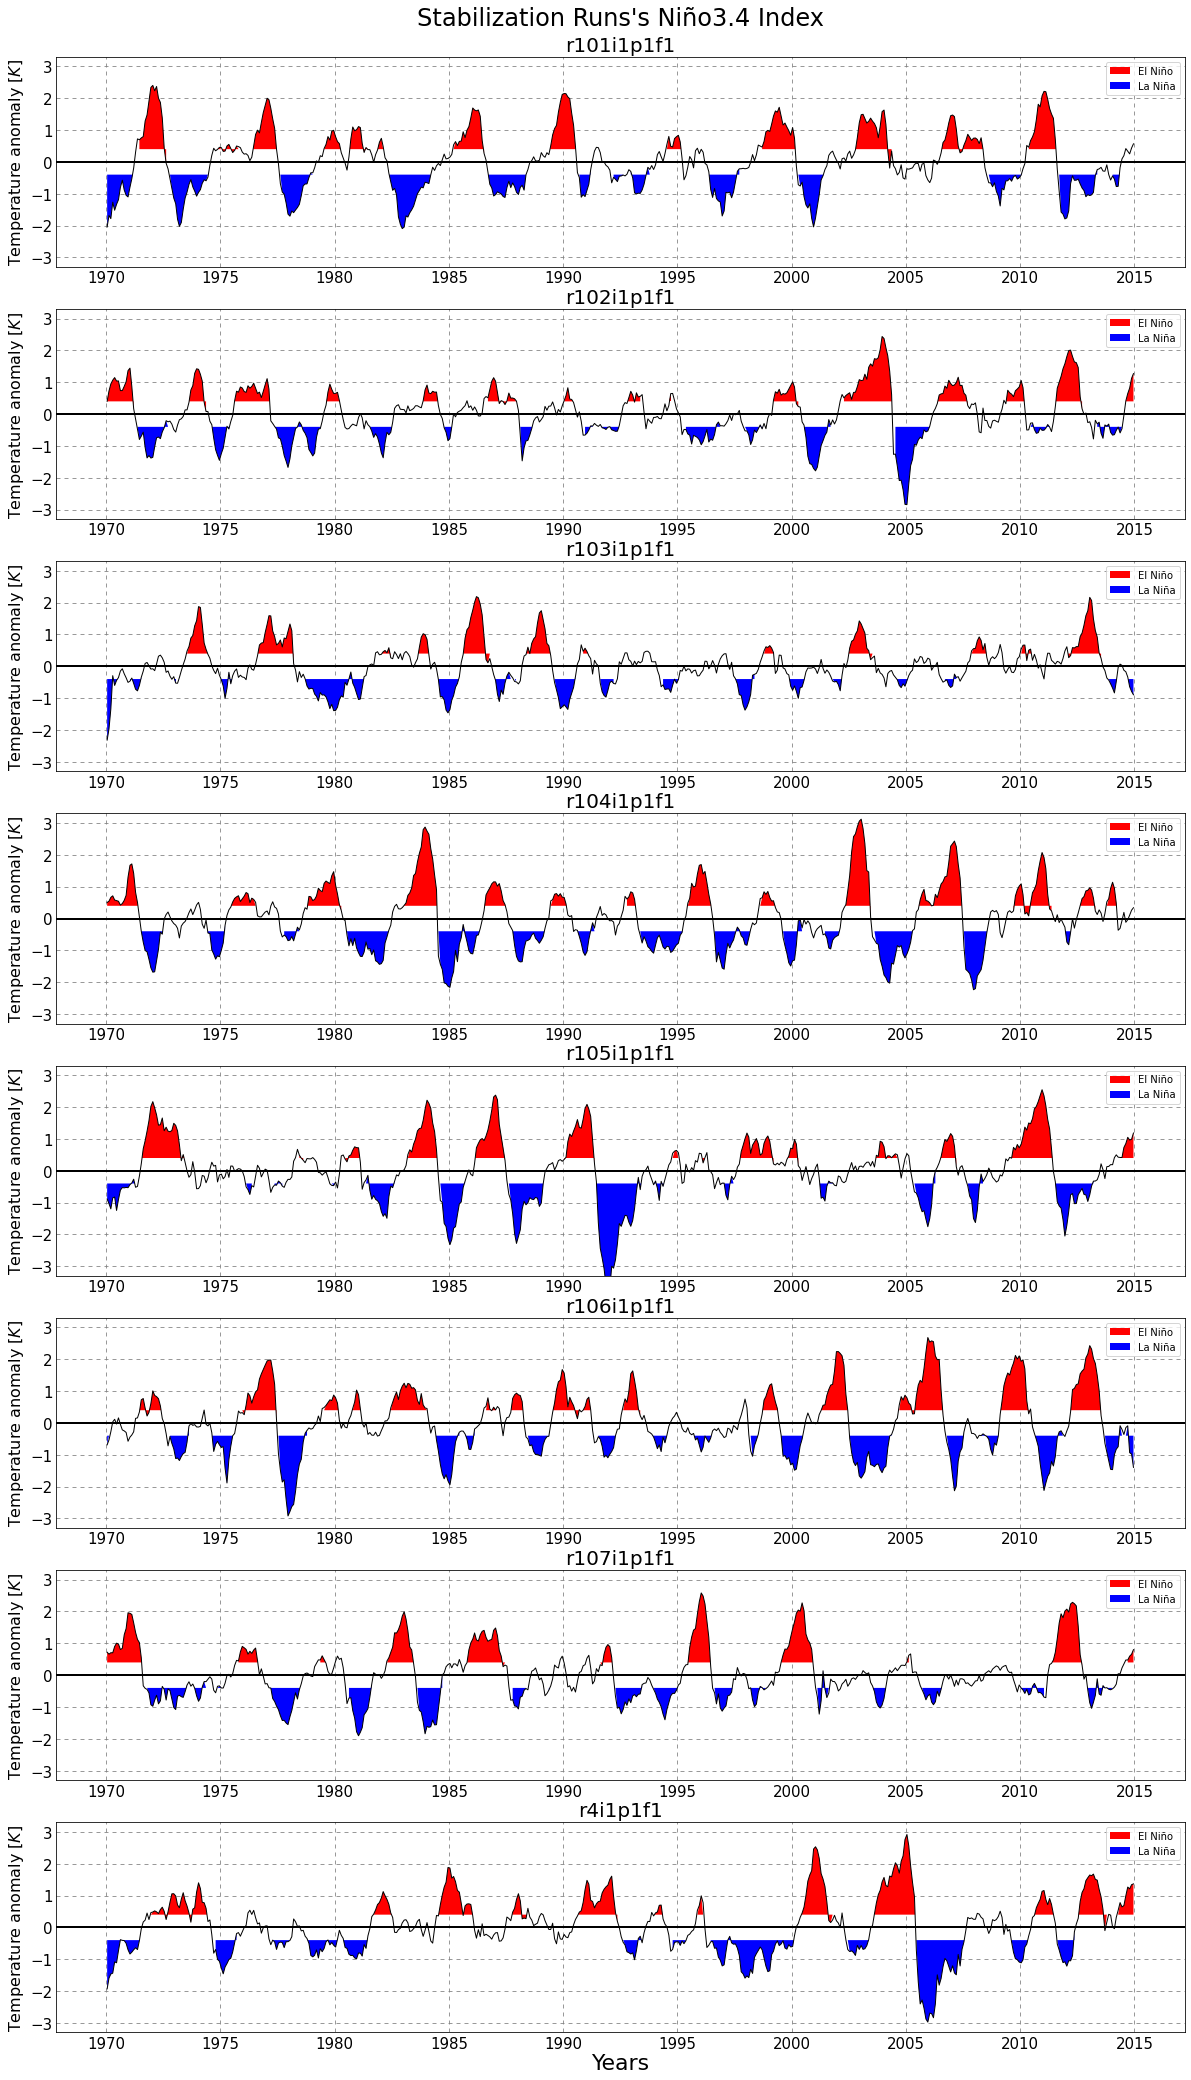

In [6]:
###################################################################################
######## (1) ############### Ninõ Index time series ###############################
############## (Running Mean Detrending, time mean over Months) ###################
############################### (SubPlot Line Plot) ###############################
###################################################################################
# Creiamo una figura e gli assi dei subplots
fig, ax = plt.subplots(nrows=len(ensamble_names), ncols=1, figsize=(16, 28))
plt.style.use('_mpl-gallery')
# Ora riempiamo ogni subplot con i dati dall'array
for i, dataset in enumerate(ensamble_names):
    ax[i].plot(Index34[i]['time'], Index34[i],  color='k', linewidth=1.0)
    ax[i].set_title('{}'.format(dataset), fontsize=20) # Niño3.4 Index - Running Mean detrended - Montly Averaged
    # Fill between the values of Index >= 0.4 and Index <= -0.4 with red and blue colors, respectively
    ax[i].fill_between(Index34[i]['time'], 0.4,  Index34[i],
                       where = Index34[i].rolling(time=6, min_periods=1, center=True).mean().dropna("time")>=0.4, facecolor='red', interpolate=True, label='El Niño')
    ax[i].fill_between(Index34[i]['time'], -0.4,  Index34[i],
                       where = Index34[i].rolling(time=6, min_periods=1, center=True).mean().dropna("time")<=-0.4, facecolor='blue', interpolate=True, label='La Niña')
    # Add a legend on the Axes
    ax[i].legend(loc = 'upper right')
    # Set title and x-y axis labels for the Axes
    #axs[i].set_xlabel('Years', fontsize=12)
    ax[i].set_ylabel('Temperature anomaly ' r'$[K]$', fontsize=16)
    # Set y-Axes range
    ax[i].set_ylim(-3.3, 3.3)
    # Set x-Axes ticks & labels
    # ax[i].set_xticks(Yticks[i])
    # ax[i].set_xticklabels(Ylabels[i])

# Set a global title for the plot
fig.suptitle('Stabilization Runs\'s Niño3.4 Index', y=1.015, fontsize=24) #y=1.015, y=1
fig.supxlabel('Years', y=-0.01, fontsize=22) #y=-0.01,

for ax in ax:
   # Adds gridlines to the Axes
   ax.grid(linestyle='--', color='gray')
   # Add a horizontal line in the Axes
   ax.axhline(y=0.0, color='black', linewidth=2)

#plt.subplots_adjust(hspace=0.25) #wspace=5
# # Display the figure
plt.show()
# Save the current figure to a file
fig.savefig(common_dir_proj+Dir_images+'EnsambleHist-NinoIndex34.pdf', bbox_inches='tight')
fig.savefig(common_dir_proj+Dir_images+'EnsambleHist-NinoIndex34.jpg', bbox_inches='tight', dpi=150)

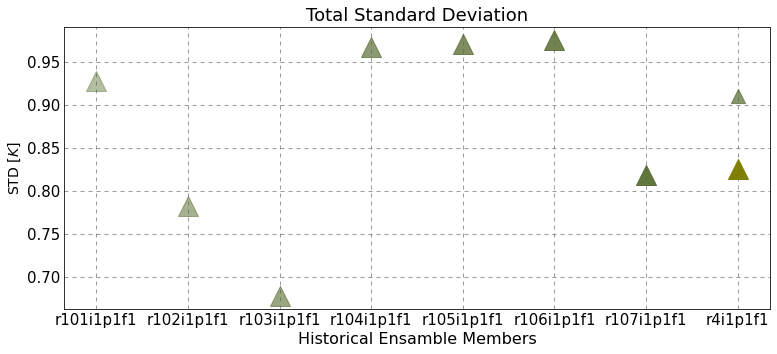

In [5]:
###################################################################################
############################ Full time series STD #################################
######### (1) ################### (Scatter Plot) ##################################
###################################################################################
plt.style.use('_mpl-gallery')
fig, ax = plt.subplots(figsize=(10, 4))
for i, ensamble in enumerate(ensamble_names):
   ax.scatter(ensamble, Dataset_elab[ensamble][3], s=400, color=colors[i], marker="^", alpha=alphas[i])
ax.scatter(ensamble_names[7], Dataset_elab[ensamble][4], s=200, color=colors[1], marker="^", alpha=0.7) # ultimi 45 anni
ax.grid(linestyle='--', color='gray')
ax.set_title('Total Standard Deviation', fontsize=18)
ax.set_xlabel('Historical Ensamble Members', fontsize=16)
ax.set_ylabel('STD ' r'$[K]$', fontsize=14)
# Display the figure
plt.show()
# Save the current figure to a file
fig.savefig(common_dir_proj+Dir_images+'EnsambleHist-stdT.pdf', bbox_inches='tight')
fig.savefig(common_dir_proj+Dir_images+'EnsambleHist-stdT.jpg', bbox_inches='tight', dpi=150)

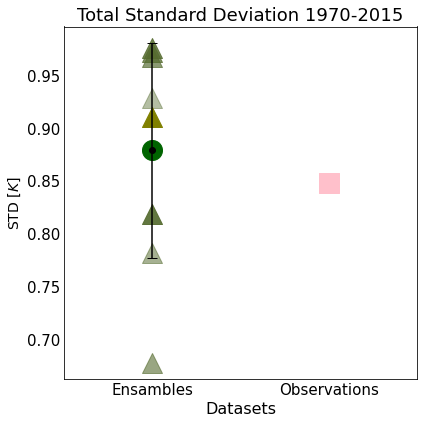

In [6]:
std_total = std_T.copy()
std_total[len(std_total)-1] = std_window[len(std_T)-1]
ensamble_mean = np.sum(std_total)/len(std_total)
ensamble_mean_err = np.std(std_total)#/np.sqrt(len(std_total))
# Posizioni numeriche per i gruppi
x_positions = [0, 1, 2, 3, 4]
###################################################################################
######################### Full time series STD + OBS ##############################
######### (1) ################ (Scatter Plot) #####################################
###################################################################################
plt.style.use('_mpl-gallery')
fig, ax = plt.subplots(figsize=(5, 5))
#ax.set_xticks(np.arange(0,4,1))
for i in range(len(ensamble_names)):
   ax.scatter(x_positions[1], std_total[i], s=400, color=colors[i], marker="^", alpha=alphas[i])
ax.scatter(x_positions[1], ensamble_mean, s=400, color='darkgreen', marker="o", alpha=1)
ax.errorbar(x_positions[1], ensamble_mean, yerr=ensamble_mean_err, fmt='o', color='k', capsize=5)
ax.scatter(x_positions[3], std_window_obs, s=400, color='pink', marker="s", alpha=1)
# Personalizza i tick dell'asse x
ax.set_xticks(x_positions)
ax.set_xticklabels(['', 'Ensambles', '', 'Observations', ''])
ax.grid(linestyle='')
ax.set_title('Total Standard Deviation 1970-2015', fontsize=18)
ax.set_xlabel('Datasets', fontsize=16)
ax.set_ylabel('STD ' r'$[K]$', fontsize=14)
#plt.tight_layout()
# Display the figure
plt.show()
# Save the current figure to a file
fig.savefig(common_dir_proj+Dir_images+'EnsambleHistObs-stdT.pdf', bbox_inches='tight')
fig.savefig(common_dir_proj+Dir_images+'EnsambleHistObs-stdT.jpg', bbox_inches='tight', dpi=150)